# FNet fibril dataframe example

In this example, we will generate a fibril dataframe from first 20 frames of a subregion (10 $\mu$m by 10 $\mu$m) of our experiment #1 data 

In [1]:
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

img_shape = (160, 160, 128)

In [2]:
import numpy as np
import pandas as pd
import scipy.io

## Import images

In [3]:
imgs = np.load('training_example/imgs.npy', allow_pickle=True)
life_imgs = np.load('training_example/life_imgs.npy', allow_pickle=True)

In [4]:
N_region=imgs.shape[0]
N_imglen=imgs.shape[1]

regions=range(0,N_region)
prediction_sequence_shape=np.append(np.array(img_shape),[len(regions),N_imglen])

## Load a model

In [5]:
from FNet import FNet

base_feature = 4

In [6]:
model=FNet(base_feature, img_shape)
model.load_weights('training_example/model/0108_FRa10_1216')

## Generate a prediction seqeunce

In [7]:
import sklearn.cluster as cluster
from scipy import stats

import time
import gc

In [8]:
def one_img(imgs, region=0, timepoint=0, channel=0): #get an image from an img sequence
	'''
	channel=0 for acceptor
	channel=1 for donor
	'''
	new_img=np.zeros(img_shape[0:2]) #to match with train image size
	if region<imgs.shape[0] and timepoint<imgs.shape[1]:
		mat_img=imgs[region,timepoint][0,channel]
		new_img[0:mat_img.shape[0],0:mat_img.shape[1]]=mat_img
	return new_img

In [9]:
def one_shot_predictor(model, next_img, prev_cl=0, norm_factor=100., img_shape = (160,160,128)): #a prediction with 10px padding
	img_shape = model.input_shape[1:]
	if not isinstance(prev_cl, (list, tuple, np.ndarray)):
		empty_pred=np.zeros(img_shape)
		prev_cl=empty_pred
		bkg = np.median(next_img[0:150,0:150])
		empty_pred[...,1]=bkg#np.random.poisson(np.median(next_img),empty_pred.shape[0:2]) #fill the bkg channel
	else:
		bkg = prev_cl[:,:,1].mean()
	img=np.zeros(img_shape)
	img[:,:,0]=next_img
	img[:,:,1:]=prev_cl[:,:,1:]
	
	img[:,150:160,0]=bkg
	img[150:160,:,0]=bkg
	
	img/=norm_factor
	
	return norm_factor*model.predict(np.expand_dims(img,axis=0))[0] #expand dim to make it a batch of size 1

In [10]:
def find_z_available(cluster_img): #find empty layers
    z_available=np.arange(0,cluster_img.shape[2])[np.isclose([np.max(cluster_img[:,:,z]) for z in range(0,cluster_img.shape[2])],0)]
    
    return z_available[z_available>1]

def find_z_unavailable(cluster_img): #find occupied layers
    z_available=find_z_available(cluster_img)
    return [z for z in range(2,cluster_img.shape[2]) if not np.isin(z,z_available)]

In [11]:
def get_cluster_image(new_pred, next_img, prev_cl=0, clustering=True, minimumSize=10, dist_crit=2):
    '''
    Find clusters in an image.
    
    The followings are for known clusters. For new cluseters, bkg threshold applied automatically
    
    clustering=True # only choose the biggest cluster above bkg
    '''
    img_shape=new_pred.shape
    
    cluster_image=new_pred.copy()
    bkg=np.mean(new_pred[...,1])

    if not isinstance(prev_cl, (list, tuple, np.ndarray)):
        z_available=np.arange(2,img_shape[2])
        z_unavailable=[]
    else:
        z_available=find_z_available(prev_cl)
        z_unavailable=find_z_unavailable(prev_cl)
        
    #Known clusters bkg thresholding
    for z in z_unavailable:
        new_pred_z=cluster_image[...,z]
        new_pred_z[(new_pred_z) <= bkg]=0 #erase signals below threshold
    
    for z in z_available:
        cluster_image[...,z]=0
    
    #clustering of known clusters' signals
    if clustering:
        for z in z_unavailable:
            new_pred_z=cluster_image[...,z].copy()
            cluster_image[...,z]=0
            
            z_clusters_locations=np.array(np.nonzero(new_pred_z>bkg)).T
            
            if z_clusters_locations.shape[0]>=minimumSize: #more than minimumSize pixel of cluster
                labels=cluster.AgglomerativeClustering(n_clusters=None, linkage='single',distance_threshold=dist_crit).fit_predict(z_clusters_locations)

                largest_index=stats.mode(labels)
                largest_index=largest_index[0]

                cluster_locations=[x for x in z_clusters_locations[labels==largest_index,:]]
                    
                for x in cluster_locations:
                    cluster_image[tuple(np.append(x,z))]=new_pred_z[tuple(x)]

    # for new clusters
    new_clusters=(new_pred[...,0])>bkg
    
    if np.any(new_clusters) and z_available.size>0:
        new_clusters_locations=np.array(np.nonzero(new_clusters)).T
        if new_clusters_locations.shape[0]>=minimumSize: #more than minimumSize pixel of new cluster
            labels=cluster.AgglomerativeClustering(n_clusters=None, linkage='single',distance_threshold=dist_crit).fit_predict(new_clusters_locations)
            n_new=0
            z_index=0
            for index in np.unique(labels):
                if not z_available.size>z_index: #no more space
                    print('No more space')
                    break
                    
                cluster_locations=[x for x in new_clusters_locations[labels==index,:]]
                if len(cluster_locations) < minimumSize: #skip small cluster
                    continue
                else:
                    n_new+=1
                    z_index+=1
                    
                for x in cluster_locations:
                        cluster_image[tuple(np.append(x,z_available[z_index-1]))]=new_pred[tuple(np.append(x,0))]
                    
        else:
            n_new=0
    else:
        n_new=0
    
    #normalize
    bkg_layer = cluster_image[...,1:2].copy() #preserve bkg guess
    
    cluster_image[...,0:2] = 0
    img_sum=cluster_image.sum(2)
        
    for nonzero_index in np.argwhere(img_sum>0):
        cluster_image[nonzero_index[0],nonzero_index[1],:]/=img_sum[nonzero_index[0],nonzero_index[1]];
    
    next_img = np.expand_dims(next_img,axis=-1)
    
    cluster_image *= next_img
    
    cluster_image[...,0:1] = next_img
    cluster_image[...,1:2] = bkg_layer
    
    return cluster_image

In [12]:
prediction_sequence=np.zeros(prediction_sequence_shape)

In [22]:
for region_index in range(0,len(regions)):
    t0 = time.time()
    print(f'Working on Region {regions[region_index]}')
    next_img = one_img(imgs,regions[region_index],0)
    new_pred = one_shot_predictor(model, next_img)
    new_cl = get_cluster_image(new_pred,next_img)
    prediction_sequence[...,region_index,0] = new_cl
    prev_cl = new_cl
    for imgseq in range(1,N_imglen):
        try:
            next_img = one_img(imgs,regions[region_index],imgseq)
            new_pred = one_shot_predictor(model, next_img, prev_cl=prev_cl)
            new_cl = get_cluster_image(new_pred, next_img, prev_cl=prev_cl)
            prediction_sequence[...,region_index,imgseq]=new_cl
            prev_cl = new_cl
        except: #due to the termination of imaging at the last frame
            print('a break at Region=',regions[region_index],',Time=',imgseq)
            break
        t1 = time.time()
        print(f't == {imgseq} finished at {(t1 - t0):.4}s', end='\r')
    t1 = time.time()
    print('')
    print(f'Region {regions[region_index]} took {(t1 - t0):.4}s')
    gc.collect()

Working on Region 0
t == 66 finished at 124.9s
Region 0 took 124.9s


## Inspect prediction results

In [23]:
import matplotlib.pyplot as plt

In [24]:
def plot_25_clusters(next_cluster_image): #plot first 25 layers
    plt.figure(figsize=(15,15))
    for i in range (0,25):
        plt.subplot(5,5,i+1)
        plt.imshow(next_cluster_image[0:150,0:150,i])
        plt.title(f'Max={next_cluster_image[0:150,0:150,i].max():3.2}')

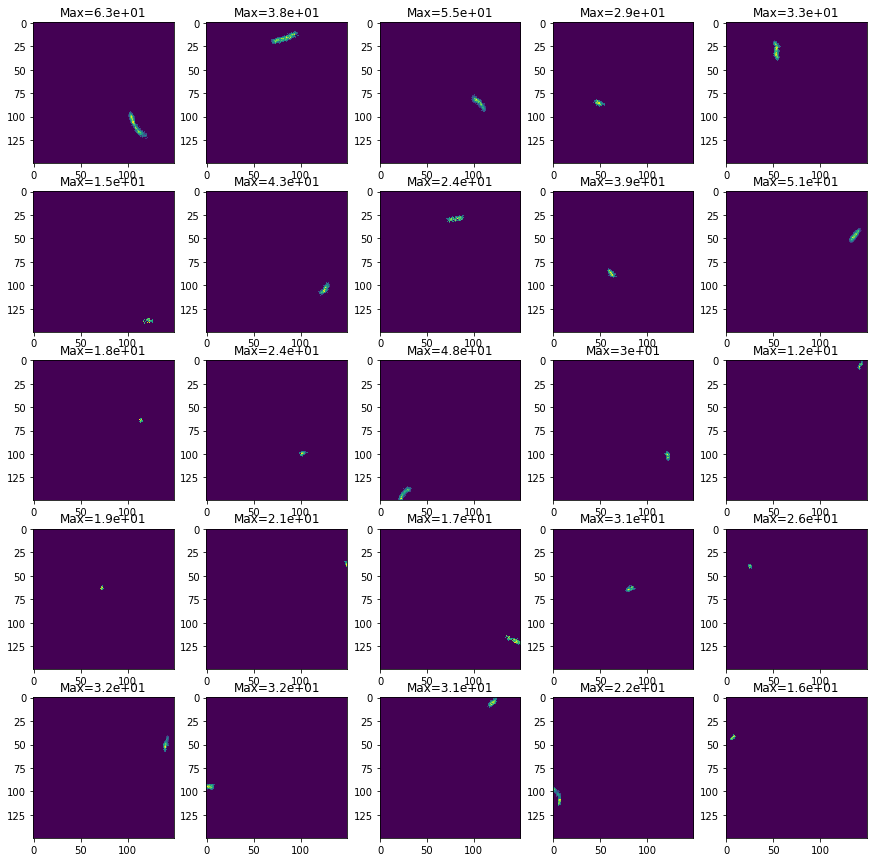

In [26]:
plot_25_clusters(prediction_sequence[:,:,10:40,0,40])

# Generate a dataframe

In [39]:
def is_boundary(locations, img_shape = (160,160,128), padding = 10):
    crit = 2 #width of the boundary in px
    return int(np.any((locations[0]<crit) | (locations[0]>(img_shape[0]-padding-1-crit)) | (locations[1]<crit) | (locations[1]>(img_shape[1]-padding-1-crit))))

def generate_cluster_db(prediction_sequence, imgs, life_imgs, subdir=''):
    cluster_N=0
    clusterDF=pd.DataFrame()
    PSF_mask_width = 7
    PSF_mask_size = PSF_mask_width**2
    
    non_inter_img=np.zeros(prediction_sequence.shape[0:3])
    bkg_delays_mat = scipy.io.loadmat(f'{subdir}/bkg_delays.mat')
    bkg_delays=bkg_delays_mat['bkg_delays']    
    bkg_mean_record = np.zeros(prediction_sequence.shape[4])
    
    for region in range(0,prediction_sequence.shape[3]):
        print(f'Working on Region {region}')
        for imgseq in range(0,prediction_sequence.shape[4]):
            print(f'Working on t == {imgseq}...',end='\r')
            # for FNet, we have a good estimation of the background level
            bkg_guess=prediction_sequence[0:150,0:150,1,region,imgseq].mean() * 0.9 #slightly reduce the area of bkg img estimated
            
            #calculate background information
            non_bkg_index=np.array(list(range(2, prediction_sequence.shape[2])))
            non_bkg_img=prediction_sequence[...,non_bkg_index,region,imgseq].sum(2)
            non_bkg_img=non_bkg_img[0:150,0:150]
            
            bkg_img=prediction_sequence[...,1,region,imgseq]
            bkg_img=bkg_img[0:150,0:150]
            bkg_mean=np.mean(bkg_img[(non_bkg_img<bkg_guess)])
            bkg_mean_record[imgseq] = bkg_mean
            
            bkg_delay_mean = bkg_delays[region,imgseq]
            
            non_inter_img.fill(0)
            cluster_img=prediction_sequence[...,region,imgseq].copy()
            z_filled=find_z_unavailable(cluster_img)

            if len(z_filled)==0:
                z_filled_old=[]
                continue;

            if len(z_filled)==prediction_sequence.shape[2]-2: #cluster channels are completely filled
                break;
                
            one_lifeimg_Acc_org=one_img(life_imgs,region=region,timepoint=imgseq,channel=0)
            one_lifeimg_Don_org=one_img(life_imgs,region=region,timepoint=imgseq,channel=1)       
            one_img_acc_org=one_img(imgs,region=region,timepoint=imgseq,channel=0)
            one_img_don_org=one_img(imgs,region=region,timepoint=imgseq,channel=1)

            for z in z_filled:
                excluding_index=np.array(list(range(2,z))+list(range(z+1, prediction_sequence.shape[2])))
                including_img=prediction_sequence[...,z,region,imgseq].copy()
                excluding_img=prediction_sequence[...,excluding_index,region,imgseq].sum(2)
                #including_img[np.nonzero(excluding_img)]=0
                including_img[excluding_img>=bkg_mean]=0
                non_inter_img[...,z]=including_img
                
                backtrack = False
                bkg_mean = bkg_mean_record[imgseq]
                bkg_delay_mean = bkg_delays[region,imgseq]
                one_lifeimg_Acc=one_lifeimg_Acc_org
                one_lifeimg_Don=one_lifeimg_Don_org
                one_img_acc=one_img_acc_org
                one_img_don=one_img_don_org
                
                if imgseq==0: #first frame
                    cluster_id=cluster_N
                    cluster_N+=1
                else: #imgseq>0
                    if np.isin(z,z_filled_old): #it is not a new cluster
                        cluster_id=clusterDF[(clusterDF['Layer'] == z) & (clusterDF['Region'] == region) & (clusterDF['Timeframe']==(imgseq-1))]['ClusterID'].values[0]
                    else: #is a new cluster
                        cluster_id=cluster_N
                        cluster_N+=1
                        backtrack = True #back-track to the begining of the movie
   
                locations=np.array(np.nonzero(cluster_img[...,z]))
                locationsNI=np.array(np.nonzero(non_inter_img[...,z])) #non-intersecting locations
        
                cluster_size=locations.shape[1]
                cluster_sizeNI=locationsNI.shape[1]
                
                #acceptor info
                intenPixels_Acc=cluster_img[locations[0],locations[1],z]
                lifePixels_Acc=one_lifeimg_Acc[locations[0],locations[1]]
                
                #if its coverage is too small, then make it as large as the PSF size
                if (cluster_size < PSF_mask_size) and (cluster_sizeNI==cluster_size): #try to expand ROI, unless there is an overlap. Later these clusters can be eliminated: Size<49
                    #find the centroid
                    #print(intenPixels_Acc)
                    #print(np.array(locations[0]))
                    #print(intenPixels_Acc.sum())
                    
                    i_center = int(np.round((np.array(locations[0])*intenPixels_Acc).sum()/intenPixels_Acc.sum()))
                    j_center = int(np.round((np.array(locations[1])*intenPixels_Acc).sum()/intenPixels_Acc.sum()))
                    
                    i_min = max(i_center - PSF_mask_width//2, 0)
                    j_min = max(j_center - PSF_mask_width//2, 0)
                    i_max = min(i_center + PSF_mask_width//2, 149)
                    j_max = min(j_center + PSF_mask_width//2, 149)
                    
                    cluster_img_temp = cluster_img[...,z].copy()
                    cluster_img_temp[i_min:i_max+1,j_min:j_max+1]=one_img_acc[i_min:i_max+1,j_min:j_max+1]
                    
                    including_img=cluster_img_temp.copy()
                    including_img[excluding_img>=bkg_mean]=0
                    
                    locations=np.array(np.nonzero(cluster_img_temp))
                    locationsNI=np.array(np.nonzero(including_img)) #non-intersecting locations
                    
                    cluster_size=locations.shape[1]
                    cluster_sizeNI=locationsNI.shape[1]
                    
                    non_inter_img[...,z]=including_img
                    cluster_img[...,z] = cluster_img_temp
                        
                    if cluster_sizeNI< cluster_size:
                        locations = locationsNI
                        cluster_size = cluster_sizeNI
                        cluster_img[...,z] = including_img
                        backtrack = False #if there's an overlap, don't backtrack
                    #acceptor info
                    intenPixels_Acc=cluster_img[locations[0],locations[1],z]
                    lifePixels_Acc=one_lifeimg_Acc[locations[0],locations[1]]
                elif backtrack: #it's already big. So, it is not grown on the surface
                    backtrack = False
          
                if cluster_sizeNI< cluster_size:
                    backtrack = False      

                meanAccIntensity=intenPixels_Acc.mean()
                meanAccLife=lifePixels_Acc.mean()
                
                #donor info
                intenPixels_Don=one_img_don[locations[0],locations[1]]        
                lifePixels_Don=one_lifeimg_Don[locations[0],locations[1]]
                meanDonIntensity=intenPixels_Don.mean()
                meanDonLife=lifePixels_Don.mean()

                #acceptor info NI
                intenPixels_AccNI=cluster_img[locationsNI[0],locationsNI[1],z]
                lifePixels_AccNI=one_lifeimg_Acc[locationsNI[0],locationsNI[1]]
                meanAccIntensityNI=intenPixels_AccNI.mean()
                meanAccLifeNI=lifePixels_AccNI.mean()
                
                #donor info
                intenPixels_DonNI=one_img_don[locationsNI[0],locationsNI[1]]        
                lifePixels_DonNI=one_lifeimg_Don[locationsNI[0],locationsNI[1]]
                meanDonIntensityNI=intenPixels_DonNI.mean()
                meanDonLifeNI=lifePixels_DonNI.mean()
                
                meanAccIntensityNI_bkgcor=meanAccIntensityNI-bkg_mean
                meanAccLifeNI_bkgcor=np.sum(intenPixels_AccNI*lifePixels_AccNI-bkg_mean*bkg_delay_mean)/np.sum(intenPixels_AccNI-bkg_mean)
                
                boundary = is_boundary(locations)
                
                clusterDF=clusterDF.append({'Subfolder' : subdir , 'Region' : region, 'Timeframe': imgseq, 'ClusterID':cluster_id,
                                    'Layer':z, 'Locations':locations, 'LocationsNI':locationsNI,
                                    'IntenPixelsAcc': intenPixels_Acc, 'LifePixelsAcc': lifePixels_Acc,
                                    'IntenPixelsAccNI': intenPixels_AccNI, 'LifePixelsAccNI': lifePixels_AccNI,
                                    'MeanIntenAcc':meanAccIntensity, 'MeanLifeAcc':meanAccLife,
                                    'MeanIntenAccNI':meanAccIntensityNI, 'MeanLifeAccNI':meanAccLifeNI,
                                    'MeanIntenAccNI_bkgcor':meanAccIntensityNI_bkgcor, 'MeanLifeAccNI_bkgcor':meanAccLifeNI_bkgcor,
                                    'bkg_mean':bkg_mean, 'bkg_delay_mean':bkg_delay_mean,
                                    'IntenPixelsDon': intenPixels_Don, 'LifePixelsDon': lifePixels_Don,
                                    'IntenPixelsDonNI': intenPixels_DonNI, 'LifePixelsDonNI': lifePixels_DonNI,
                                    'MeanIntenDon':meanDonIntensity, 'MeanLifeDon':meanDonLife,
                                    'MeanIntenDonNI':meanDonIntensityNI, 'MeanLifeDonNI':meanDonLifeNI,
                                    'Size': cluster_size, 'SizeNI': cluster_sizeNI, 'backtrack': 0, 'backtrack_init': 0, 'Boundary': boundary} , ignore_index=True)
                if backtrack:
                    imgseq_temp = imgseq - 1
                    while imgseq_temp>-1:
                        if imgseq_temp==(imgseq - 1):
                            backtrack_init = 1
                        else:
                            backtrack_init = 0
                        
                        bkg_mean = bkg_mean_record[imgseq_temp]
                        bkg_delay_mean = bkg_delays[region,imgseq_temp]
                        
                        one_lifeimg_Acc=one_img(life_imgs,region=region,timepoint=imgseq_temp,channel=0)
                        one_lifeimg_Don=one_img(life_imgs,region=region,timepoint=imgseq_temp,channel=1)       
                        one_img_acc=one_img(imgs,region=region,timepoint=imgseq_temp,channel=0)
                        one_img_don=one_img(imgs,region=region,timepoint=imgseq_temp,channel=1)
                        
                        intenPixels_Acc=one_img_acc[locations[0],locations[1]]
                        
                        i_center = np.round((np.array(locations[0])*intenPixels_Acc).sum()/intenPixels_Acc.sum())
                        j_center = np.round((np.array(locations[1])*intenPixels_Acc).sum()/intenPixels_Acc.sum())
                        
                        if np.isnan(i_center):
                            i_center = int(round(np.array(locations[0]).mean()))
                        else:
                            i_center = int(i_center)
                        
                        if np.isnan(j_center):
                            j_center = int(round(np.array(locations[1]).mean()))
                        else:
                            j_center = int(j_center)
                        
                        i_min = max(i_center - PSF_mask_width//2, 0)
                        j_min = max(j_center - PSF_mask_width//2, 0)
                        i_max = min(i_center + PSF_mask_width//2, 149)
                        j_max = min(j_center + PSF_mask_width//2, 149)
                        
                        cluster_img[...,z].fill(0)
                        cluster_img[i_min:i_max+1,j_min:j_max+1,z]=one_img_acc[i_min:i_max+1,j_min:j_max+1]
                        
                        including_img=cluster_img[...,z].copy()
                        # for this backtracking, non-intersecting img will not be calculated

                        locations=np.array(np.nonzero(cluster_img[...,z]))
                        locationsNI=locations

                        cluster_size=locations.shape[1]
                        cluster_sizeNI=locationsNI.shape[1]

                        #acceptor info
                        intenPixels_Acc=cluster_img[locations[0],locations[1],z]
                        lifePixels_Acc=one_lifeimg_Acc[locations[0],locations[1]]
                        meanAccIntensity=intenPixels_Acc.mean()
                        meanAccLife=lifePixels_Acc.mean()

                        #donor info
                        intenPixels_Don=one_img_don[locations[0],locations[1]]        
                        lifePixels_Don=one_lifeimg_Don[locations[0],locations[1]]
                        meanDonIntensity=intenPixels_Don.mean()
                        meanDonLife=lifePixels_Don.mean()

                        #acceptor info NI
                        intenPixels_AccNI=cluster_img[locationsNI[0],locationsNI[1],z]
                        lifePixels_AccNI=one_lifeimg_Acc[locationsNI[0],locationsNI[1]]
                        meanAccIntensityNI=intenPixels_AccNI.mean()
                        meanAccLifeNI=lifePixels_AccNI.mean()

                        #donor info
                        intenPixels_DonNI=one_img_don[locationsNI[0],locationsNI[1]]        
                        lifePixels_DonNI=one_lifeimg_Don[locationsNI[0],locationsNI[1]]
                        meanDonIntensityNI=intenPixels_DonNI.mean()
                        meanDonLifeNI=lifePixels_DonNI.mean()

                        meanAccIntensityNI_bkgcor=meanAccIntensityNI-bkg_mean
                        meanAccLifeNI_bkgcor=np.sum(intenPixels_AccNI*lifePixels_AccNI-bkg_mean*bkg_delay_mean)/np.sum(intenPixels_AccNI-bkg_mean)

                        boundary = is_boundary(locations)
                        
                        clusterDF=clusterDF.append({'Subfolder' : subdir , 'Region' : region, 'Timeframe': imgseq_temp, 'ClusterID':cluster_id,
                                            'Layer':z, 'Locations':locations, 'LocationsNI':locationsNI,
                                            'IntenPixelsAcc': intenPixels_Acc, 'LifePixelsAcc': lifePixels_Acc,
                                            'IntenPixelsAccNI': intenPixels_AccNI, 'LifePixelsAccNI': lifePixels_AccNI,
                                            'MeanIntenAcc':meanAccIntensity, 'MeanLifeAcc':meanAccLife,
                                            'MeanIntenAccNI':meanAccIntensityNI, 'MeanLifeAccNI':meanAccLifeNI,
                                            'MeanIntenAccNI_bkgcor':meanAccIntensityNI_bkgcor, 'MeanLifeAccNI_bkgcor':meanAccLifeNI_bkgcor,
                                            'bkg_mean':bkg_mean, 'bkg_delay_mean':bkg_delay_mean,
                                            'IntenPixelsDon': intenPixels_Don, 'LifePixelsDon': lifePixels_Don,
                                            'IntenPixelsDonNI': intenPixels_DonNI, 'LifePixelsDonNI': lifePixels_DonNI,
                                            'MeanIntenDon':meanDonIntensity, 'MeanLifeDon':meanDonLife,
                                            'MeanIntenDonNI':meanDonIntensityNI, 'MeanLifeDonNI':meanDonLifeNI,
                                            'Size': cluster_size, 'SizeNI': cluster_sizeNI, 'backtrack': 1, 'backtrack_init': backtrack_init, 'Boundary': boundary} , ignore_index=True)
                        
                        imgseq_temp-=1
            z_filled_old=z_filled #save previous cluster z informations
        gc.collect()

    return clusterDF.copy()

In [37]:
clusterDF=pd.DataFrame()

In [38]:
clusterDF=clusterDF.append(generate_cluster_db(prediction_sequence, imgs, life_imgs, subdir='training_example'))

Working on Region 0


/usr/local/Caskroom/miniconda/base/envs/tf-env-Ab/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: Mean of empty slice.
/usr/local/Caskroom/miniconda/base/envs/tf-env-Ab/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: Mean of empty slice.
/usr/local/Caskroom/miniconda/base/envs/tf-env-Ab/lib/python3.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning: Mean of empty slice.
/usr/local/Caskroom/miniconda/base/envs/tf-env-Ab/lib/python3.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: Mean of empty slice.
/usr/local/Caskroom/miniconda/base/envs/tf-env-Ab/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in double_scalars


In [40]:
clusterDF

,Boundary,ClusterID,IntenPixelsAcc,IntenPixelsAccNI,IntenPixelsDon,IntenPixelsDonNI,Layer,LifePixelsAcc,LifePixelsAccNI,LifePixelsDon,...,MeanLifeDonNI,Region,Size,SizeNI,Subfolder,Timeframe,backtrack,backtrack_init,bkg_delay_mean,bkg_mean
0,1.0,0.0,"[3.4739111005231176, 0.7298942870398241, 0.763...","[3.4739111005231176, 0.7298942870398241, 0.763...","[0.0, 0.0, 0.7633896701384437, 5.5683137848984...","[0.0, 0.0, 0.7633896701384437, 5.5683137848984...",2.0,"[1.288e-08, 4.519e-09, 6.1568e-09, 3.020666666...","[1.288e-08, 4.519e-09, 6.1568e-09, 3.020666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.521...",...,1.911688e-09,0.0,47.0,47.0,training_example,0.0,0.0,0.0,4.837891e-09,2.940400
1,1.0,1.0,"[1.0207650162140032, 3.062295048641877, 2.0415...","[1.0207650162140032, 3.062295048641877, 2.0415...","[0.0, 0.0, 0.0, 0.0, 1.0207650162140032, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0207650162140032, 0.0, ...",3.0,"[0.0, 4.4810000000000006e-09, 6.556e-09, 1.498...","[0.0, 4.4810000000000006e-09, 6.556e-09, 1.498...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,7.155263e-10,0.0,38.0,38.0,training_example,0.0,0.0,0.0,4.837891e-09,2.940400
2,1.0,2.0,"[2.8835629673323515, 1.063054500919827, 3.8567...","[2.8835629673323515, 1.063054500919827, 3.8567...","[0.5767125934664703, 3.1891635027594507, 0.0, ...","[0.5767125934664703, 3.1891635027594507, 0.0, ...",5.0,"[8.245555555555556e-09, 1.0033333333333332e-08...","[8.245555555555556e-09, 1.0033333333333332e-08...","[2.4145e-09, 3.0869999999999998e-09, 7.4446666...",...,4.769623e-09,0.0,36.0,36.0,training_example,0.0,0.0,0.0,4.837891e-09,2.940400
3,1.0,3.0,"[2.0415300324279846, 2.0415300324279846, 3.062...","[2.0415300324279846, 2.0415300324279846, 3.062...","[7.145355113497812, 0.0, 1.0207650162139923, 3...","[7.145355113497812, 0.0, 1.0207650162139923, 3...",6.0,"[1.19e-09, 2.9075999999999998e-09, 2.707333333...","[1.19e-09, 2.9075999999999998e-09, 2.707333333...","[3.7739999999999996e-09, 0.0, 5.9e-09, 4.7525e...",...,3.156809e-09,0.0,43.0,43.0,training_example,0.0,0.0,0.0,4.837891e-09,2.940400
4,1.0,4.0,"[1.020765016213959, 1.0207650162139812, 1.0000...","[1.020765016213959, 1.0207650162139812, 1.0000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.0,"[4.994666666666666e-09, 4.170499999999999e-09,...","[4.994666666666666e-09, 4.170499999999999e-09,...","[5.0456363636363644e-09, 5.707142857142857e-09...",...,2.036416e-09,0.0,38.0,38.0,training_example,0.0,0.0,0.0,4.837891e-09,2.940400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11428,1.0,383.0,"[1.0203630722467087, 2.0407261444934397, 2.040...","[1.0203630722467087, 2.0407261444934397, 2.040...","[0.0, 0.0, 0.0, 0.0, 2.040726144493506, 3.0610...","[0.0, 0.0, 0.0, 0.0, 2.040726144493506, 3.0610...",94.0,"[1.9748e-09, 1.8874285714285715e-09, 1.3364999...","[1.9748e-09, 1.8874285714285715e-09, 1.3364999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,1.909091e-10,0.0,44.0,44.0,training_example,4.0,1.0,0.0,4.726785e-09,3.126466
11429,1.0,383.0,"[4.081480936861471, 1.0203702342154009, 4.0814...","[4.081480936861471, 1.0203702342154009, 4.0814...","[0.0, 1.0203702342154009, 0.0, 1.0203702342154...","[0.0, 1.0203702342154009, 0.0, 1.0203702342154...",94.0,"[1.4213333333333334e-09, 2.401111111111111e-09...","[1.4213333333333334e-09, 2.401111111111111e-09...","[0.0, 0.0, 0.0, 1.658e-09, 0.0, 1.454e-09, 0.0...",...,9.452381e-10,0.0,42.0,42.0,training_example,3.0,1.0,0.0,4.756360e-09,2.940033
11430,1.0,383.0,"[2.0423625592305323, 4.084725118460977, 1.0211...","[2.0423625592305323, 4.084725118460977, 1.0211...","[1.0211812796152662, 0.0, 1.0211812796152662, ...","[1.0211812796152662, 0.0, 1.0211812796152662, ...",94.0,"[2.718e-09, 2.48e-09, 1.5566666666666667e-09, ...","[2.718e-09, 2.48e-09, 1.5566666666666667e-09, ...","[0.0, 0.0, 0.0, 1.5295e-08, 0.0, 0.0, 0.0, 2.4...",...,1.637244e-09,0.0,45.0,45.0,training_example,2.0,1

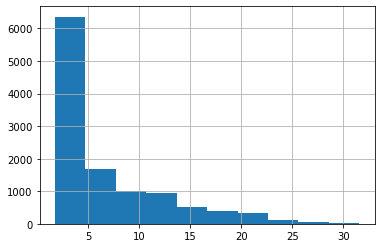

In [41]:
clusterDF.MeanIntenAcc.hist()

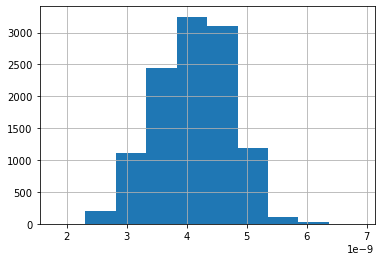

In [42]:
clusterDF.MeanLifeAcc.hist()

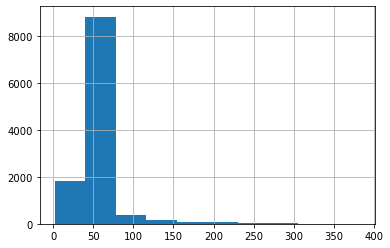

In [43]:
clusterDF.Size.hist()